#### First I need to import the libraries I'll be using through the project

In [1]:
# Import relevant libraries

!pip install geopy
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import urllib.request
import urllib.parse
import urllib.error
import ssl
import re

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import io

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install beautifulsoup4
!pip install folium

import folium # map rendering library

import seaborn as sns
from scipy.stats import pearsonr

from bs4 import BeautifulSoup as BS
!pip install geocoder

!pip install lxml

import pickle

print('Libraries imported.')

     |████████████████████████████████| 112kB 8.9MB/s eta 0:00:01
     |████████████████████████████████| 122kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 102kB 5.6MB/s ta 0:00:011
     |████████████████████████████████| 829kB 26.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 5.5MB 6.1MB/s eta 0:00:01
Libraries imported.


## Scrapping data

#### The first data I need is the list of all the neighborhood from Asuncion, for this purpose i'll be using the table of neighborhood from GeoHidroInformatica from Itaipu that contains data such neighborhood name, district name, department name (equivalent to states but with no power), quantity of houses and codes for all of these fields aswell  a field with mulipolygon data that contain delimeters for each neighboord

In [2]:
# Get data from the url in csv format
loaded = False
try:
    with open('df_location.pkl', 'rb') as f:
        df = pickle.load(f)
    print('location data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    url= 'http://geohidroinformatica.itaipu.gov.py/geoserver/wfs?typename=cih%3Aparaguay_2012_barrrios_localidades_wgs84&outputFormat=csv&version=1.0.0&request=GetFeature&service=WFS'
    data= requests.get(url).content

    df=pd.read_csv(io.StringIO(data.decode('utf-8')))
    
    # Let's persists this in local file system
    with open('df_location.pkl', 'wb') as f:
        pickle.dump(df, f)



location data loaded.


#### Let's take a quick look of the data

In [3]:
df.head()

,FID,the_geom,objectid,dpto,distrito,dpto_desc,dist_desc,area,bar_loc,barlo_desc,cant_viv,codigo,superf,cartodb_id,created_at,updated_at
0,paraguay_2012_barrrios_localidades_wgs84.1,MULTIPOLYGON (((587373.3750000016 7128761.5000...,3951,4,6,GUAIRA,GENERAL EUGENIO A. GARAY,6,290,POTRERO,189,4066290,13.45,3947,2016-03-03T00:00:00,2016-03-03T00:00:00
1,paraguay_2012_barrrios_localidades_wgs84.2,MULTIPOLYGON (((615905.1251000088 7033845.0001...,4561,7,17,ITAPUA,OBLIGADO,6,160,COLONIA MORENA'I,73,7176160,64.02,4557,2016-03-03T00:00:00,2016-03-03T00:00:00
2,paraguay_2012_barrrios_localidades_wgs84.3,MULTIPOLYGON (((628832.8504000165 7005580.7363...,4603,7,15,ITAPUA,JESUS,6,140,COLONIA GUARANI,87,7156140,20.93,4599,2016-03-03T00:00:00,2016-03-03T00:00:00
3,paraguay_2012_barrrios_localidades_wgs84.4,MULTIPOLYGON (((716204.2597003381 7207703.7080...,29,10,20,ALTO PARANA,SANTA FE DEL PARANA,6,430,ASENT. NIÑO JESUS,10,10206430,1.08,28,2016-03-03T00:00:00,2016-03-03T00:00:00
4,paraguay_2012_barrrios_localidades_wgs84.5,MULTIPOLYGON (((719086.0001003634 7236203.0001...,79,10,17,ALTO PARANA,MBARACAYU,6,260,GLEVA 5 MBARACAYU,74,10176260,43.43,78,2016-03-03T00:00:00,2016-03-03T00:00:00


#### I'll inspect the columns names in order to select the ones that i would use

In [4]:
df.columns

Index(['FID', 'the_geom', 'objectid', 'dpto', 'distrito', 'dpto_desc',
       'dist_desc', 'area', 'bar_loc', 'barlo_desc', 'cant_viv', 'codigo',
       'superf', 'cartodb_id', 'created_at', 'updated_at'],
      dtype='object')

#### I'll use the following fields:
- distrito = contains the code of the district
- dpto_desc = contains the name of the department
- dist_desc = contains the name of the district or city
- barlo_desc = contains the name of the neighborhood
- cant_viv = contains the name of the houses on each neighborhood

In [5]:
df_as = df[['distrito', 'dpto_desc',
       'dist_desc', 'bar_loc', 'barlo_desc', 'cant_viv']].copy()

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv
0,6,GUAIRA,GENERAL EUGENIO A. GARAY,290,POTRERO,189
1,17,ITAPUA,OBLIGADO,160,COLONIA MORENA'I,73
2,15,ITAPUA,JESUS,140,COLONIA GUARANI,87
3,20,ALTO PARANA,SANTA FE DEL PARANA,430,ASENT. NIÑO JESUS,10
4,17,ALTO PARANA,MBARACAYU,260,GLEVA 5 MBARACAYU,74


#### As the main focus of this project will be analyze the neighborhoods of Asuncion, I'll filter the dataframe with just the rows that correspond to this city

In [6]:
df_as = df_as[df_as['dpto_desc'] == 'ASUNCION']

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066
1722,0,ASUNCION,ASUNCION,58,MANORA,502


#### Lets take a look to the shape of the new dataframe

In [7]:
df_as.shape

(68, 6)

##### The quantity of rows agrees with the official quantity of neighborhood of the city

#### Now that I have the data from the neighborhoods of Asuncion, the next step is to get the coordinates from each one, to accomplish this, first i need to create a new field that contains some kind of adress of the neighborhood, for this task I'll be joinning the Neighborhood name, city name and a string value with the word 'Paraguay' as the country name. 
#### After completing this step, I'm going to use geocode to find the coordinate for each neighborhood.

In [8]:
df_as['Adress'] = df['barlo_desc'].map(str) + ', ' + df['dist_desc'].map(str) + ', ' + 'PARAGUAY'

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA..."
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY"
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY"
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY"
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY"


In [9]:
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent='myGeocoder')

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df_as['location'] = df_as['Adress'].apply(geocode)


In [10]:
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_as['point'] = df_as['location'].apply(lambda loc: tuple(loc.point) if loc else None)


In [11]:
df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA...","(Mariscal Jose Felix Estigarribia, Bernardino ...","(-25.2959236, -57.6081948, 0.0)"
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY","(Vista Alegre, Asunción, Región Oriental, 0013...","(-25.3144278, -57.6031993, 0.0)"
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY","(Los Laureles, Asunción, Región Oriental, Para...","(-25.3113548, -57.5770067, 0.0)"
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY","(Villa Morra, Asunción, Región Oriental, Parag...","(-25.2880157, -57.5806859, 0.0)"
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY","(Manorá, Asunción, Región Oriental, 1766, Para...","(-25.284279, -57.5726586, 0.0)"


#### Lets take a look of the shape of the new dataframe

In [12]:
df_as.shape

(68, 9)

#### After that I'm going to inspect if there is any null value for the point field that should have the coordinates

In [13]:
df_as[df_as.point.isnull()]

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point
1728,0,ASUNCION,ASUNCION,68,ZEBALLOS KUE,3724,"ZEBALLOS KUE, ASUNCION, PARAGUAY",None,None
7622,0,ASUNCION,ASUNCION,10,OBRERO INTENDENTE B. GUGGIARI,5238,"OBRERO INTENDENTE B. GUGGIARI, ASUNCION, PARAGUAY",None,None
7630,0,ASUNCION,ASUNCION,14,TTE. SILVIO PETTIROSSI,3547,"TTE. SILVIO PETTIROSSI, ASUNCION, PARAGUAY",None,None
7648,0,ASUNCION,ASUNCION,56,CAÑADA DEL YVYRAY,495,"CAÑADA DEL YVYRAY, ASUNCION, PARAGUAY",None,None
7653,0,ASUNCION,ASUNCION,33,PRESIDENTE CARLOS ANTONIO LOPEZ,3347,"PRESIDENTE CARLOS ANTONIO LOPEZ, ASUNCION, PAR...",None,None
7661,0,ASUNCION,ASUNCION,11,ROBERTO L. PETIT,3151,"ROBERTO L. PETIT, ASUNCION, PARAGUAY",None,None
7674,0,ASUNCION,ASUNCION,3,DR. GASPAR RODRIGUEZ DE FRANCIA,3068,"DR. GASPAR RODRIGUEZ DE FRANCIA, ASUNCION, PAR...",None,None
7695,0,ASUNCION,ASUNCION,22,BAÑADO CARA CARA,693,"BAÑADO CARA CARA, ASUNCION, PARAGUAY",None,None


In [14]:
df_as[df_as.point.isnull()].count()

distrito      8
dpto_desc     8
dist_desc     8
bar_loc       8
barlo_desc    8
cant_viv      8
Adress        8
location      0
point         0
dtype: int64

In [15]:
print(df_as[df_as.point.isnull()].barlo_desc)

1728                       ZEBALLOS KUE
7622      OBRERO INTENDENTE B. GUGGIARI
7630             TTE. SILVIO PETTIROSSI
7648                  CAÑADA DEL YVYRAY
7653    PRESIDENTE CARLOS ANTONIO LOPEZ
7661                   ROBERTO L. PETIT
7674    DR. GASPAR RODRIGUEZ DE FRANCIA
7695                   BAÑADO CARA CARA
Name: barlo_desc, dtype: object


#### As the dataframe have none values in specific neighborhoods, I evaluated the quantity of the rows with that value and determined that it was a low quantity, so in order to get the location data for those places I've decided to replace them manually in the barlo_desc field with the names that appears in the google maps site and then update the dataframe

#### After the replacement, I'm going to drop the adress, location and point columns, so I can repopulate them with the new values and apply again the search with geocode

In [16]:
df_as['barlo_desc'].replace({'ZEBALLOS KUE':'ZEBALLOS CUE','OBRERO INTENDENTE B. GUGGIARI':'OBRERO','TTE. SILVIO PETTIROSSI':'PETTIROSSI', 'CAÑADA DEL YVYRAY':'CAÑADA DEL YBYRAY','PRESIDENTE CARLOS ANTONIO LOPEZ':'SAJONIA','ROBERTO L. PETIT':'DR ROBERTO L PETTIT','DR. GASPAR RODRIGUEZ DE FRANCIA':'DR FRANCIA','BAÑADO CARA CARA':'SANTA ROSA'}, inplace = True)

df_as[df_as.point.isnull()]

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point
1728,0,ASUNCION,ASUNCION,68,ZEBALLOS CUE,3724,"ZEBALLOS KUE, ASUNCION, PARAGUAY",None,None
7622,0,ASUNCION,ASUNCION,10,OBRERO,5238,"OBRERO INTENDENTE B. GUGGIARI, ASUNCION, PARAGUAY",None,None
7630,0,ASUNCION,ASUNCION,14,PETTIROSSI,3547,"TTE. SILVIO PETTIROSSI, ASUNCION, PARAGUAY",None,None
7648,0,ASUNCION,ASUNCION,56,CAÑADA DEL YBYRAY,495,"CAÑADA DEL YVYRAY, ASUNCION, PARAGUAY",None,None
7653,0,ASUNCION,ASUNCION,33,SAJONIA,3347,"PRESIDENTE CARLOS ANTONIO LOPEZ, ASUNCION, PAR...",None,None
7661,0,ASUNCION,ASUNCION,11,DR ROBERTO L PETTIT,3151,"ROBERTO L. PETIT, ASUNCION, PARAGUAY",None,None
7674,0,ASUNCION,ASUNCION,3,DR FRANCIA,3068,"DR. GASPAR RODRIGUEZ DE FRANCIA, ASUNCION, PAR...",None,None
7695,0,ASUNCION,ASUNCION,22,SANTA ROSA,693,"BAÑADO CARA CARA, ASUNCION, PARAGUAY",None,None


In [17]:
df_as.drop(['Adress','location','point'], axis=1, inplace = True)

df_as['Adress'] = df_as['barlo_desc'].map(str) + ', ' + df_as['dist_desc'].map(str) + ', ' + 'PARAGUAY'

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA..."
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY"
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY"
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY"
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY"


In [18]:
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent='myGeocoder')

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df_as['location'] = df_as['Adress'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_as['point'] = df_as['location'].apply(lambda loc: tuple(loc.point) if loc else None)

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA...","(Mariscal Jose Felix Estigarribia, Bernardino ...","(-25.2959236, -57.6081948, 0.0)"
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY","(Vista Alegre, Asunción, Región Oriental, 0013...","(-25.3144278, -57.6031993, 0.0)"
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY","(Los Laureles, Asunción, Región Oriental, Para...","(-25.3113548, -57.5770067, 0.0)"
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY","(Villa Morra, Asunción, Región Oriental, Parag...","(-25.2880157, -57.5806859, 0.0)"
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY","(Manorá, Asunción, Región Oriental, 1766, Para...","(-25.284279, -57.5726586, 0.0)"


#### After the changes, I'm taking a second look to the data frame to see if there any null values left in point field

In [19]:
df_as[df_as.point.isnull()]

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point


#### As there is no more null values to deal with, I'm splitting the point field in three new columns with the latitud, longitude and altitude data obtained through geocode

In [20]:
# 4 - split point column into latitude, longitude and altitude columns
df_as[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_as['point'].tolist(), index=df_as.index)

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,barlo_desc,cant_viv,Adress,location,point,latitude,longitude,altitude
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA...","(Mariscal Jose Felix Estigarribia, Bernardino ...","(-25.2959236, -57.6081948, 0.0)",-25.295924,-57.608195,0.0
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY","(Vista Alegre, Asunción, Región Oriental, 0013...","(-25.3144278, -57.6031993, 0.0)",-25.314428,-57.603199,0.0
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY","(Los Laureles, Asunción, Región Oriental, Para...","(-25.3113548, -57.5770067, 0.0)",-25.311355,-57.577007,0.0
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY","(Villa Morra, Asunción, Región Oriental, Parag...","(-25.2880157, -57.5806859, 0.0)",-25.288016,-57.580686,0.0
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY","(Manorá, Asunción, Región Oriental, 1766, Para...","(-25.284279, -57.5726586, 0.0)",-25.284279,-57.572659,0.0


#### Now that I've all the coordinates for each neighborhood, I'm going to plot each one in a map using folium

In [21]:
address = 'ASUNCION, PY'

location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_asuncion = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_as['latitude'], df_as['longitude'], df_as['barlo_desc']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_asuncion)  
    
map_asuncion

## Now the data from Foursquare

#### First I am setting up the credentials for the Foursquare API, for sharing pourposes I am let a description of what was completed in this step and no the real data of the Client ID and Client Secret

In [22]:
CLIENT_ID = 'R53F1MJHDVUNGA1UD0VXGC0HSUISJ3VAFL5CFBFR3J4AOX44' # your Foursquare ID
CLIENT_SECRET = 'RT1VUYKQIZGSPBSOV2L4P3JIZO5GP1ATMSRRGTKAOXDWSLTU' # your Foursquare Secret
VERSION = '20200724'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R53F1MJHDVUNGA1UD0VXGC0HSUISJ3VAFL5CFBFR3J4AOX44
CLIENT_SECRET:RT1VUYKQIZGSPBSOV2L4P3JIZO5GP1ATMSRRGTKAOXDWSLTU


#### Then I am establishing the radius of distance for each location to go and get the venues data from Foursquare

In [23]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
loaded1 = False
try:
    with open('asuncion_venues.pkl', 'rb') as f:
        asuncion_venues = pickle.load(f)
    print('asuncion venues data loaded.')
    loaded1 = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded1:
    asuncion_venues = getNearbyVenues(names=df_as['barlo_desc'],
                                   latitudes=df_as['latitude'],
                                   longitudes=df_as['longitude']
                                  )
    
    # Let's persists this in local file system
    with open('asuncion_venues.pkl', 'wb') as f:
        pickle.dump(asuncion_venues, f)

asuncion_venues.head()

asuncion venues data loaded.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MARISCAL JOSE FELIX ESTIGARRIBIA,-25.283695,-57.632131,Black Cat Hostel,-25.282174,-57.633122,Hostel
1,MARISCAL JOSE FELIX ESTIGARRIBIA,-25.283695,-57.632131,Amandau,-25.282328,-57.633537,Ice Cream Shop
2,MARISCAL JOSE FELIX ESTIGARRIBIA,-25.283695,-57.632131,El Café Literario,-25.284223,-57.631144,Café
3,MARISCAL JOSE FELIX ESTIGARRIBIA,-25.283695,-57.632131,El Centro,-25.283537,-57.633017,Historic Site
4,MARISCAL JOSE FELIX ESTIGARRIBIA,-25.283695,-57.632131,Nice - La Princesa,-25.283442,-57.632732,Boutique


#### Inspection of the shape of the data frame, to get an idea of the size of data

In [26]:
asuncion_venues.shape

(1432, 7)

#### Group the quantity of venues per neighborhood

In [27]:
asuncion_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
BELLA VISTA,10,10,10,10,10,10
BOTANICO,6,6,6,6,6,6
CAÑADA DEL YBYRAY,12,12,12,12,12,12
CIUDAD NUEVA,49,49,49,49,49,49
DE LA RESIDENTA,22,22,22,22,22,22
DR FRANCIA,15,15,15,15,15,15
DR ROBERTO L PETTIT,9,9,9,9,9,9
GENERAL BERNARDINO CABALLERO,25,25,25,25,25,25
GENERAL JOSE EDUVIGIS DIAZ,17,17,17,17,17,17


In [28]:
asuncion_g1 =asuncion_venues[['Neighborhood','Venue']]

asuncion_g1 = asuncion_g1.groupby(['Neighborhood'], as_index = False).count()

asuncion_g1.head()

,Neighborhood,Venue
0,BELLA VISTA,10
1,BOTANICO,6
2,CAÑADA DEL YBYRAY,12
3,CIUDAD NUEVA,49
4,DE LA RESIDENTA,22


#### Lets classify each neighborhood into bins by the quantity of venues there is in each one, stratifying in Low, Medium and High density and then examinate the distribution of venues through neighborhood

In [29]:
bins_as = np.linspace(min(asuncion_g1["Venue"]), max(asuncion_g1["Venue"]), 4)

group_names_as1 = ['Low', 'Medium', 'High']

asuncion_g1["Venue_Density"] = pd.cut(asuncion_g1["Venue"], bins_as, labels = group_names_as1, include_lowest= True)

asuncion_g1.head()

,Neighborhood,Venue,Venue_Density
0,BELLA VISTA,10,Low
1,BOTANICO,6,Low
2,CAÑADA DEL YBYRAY,12,Low
3,CIUDAD NUEVA,49,Medium
4,DE LA RESIDENTA,22,Low


In [30]:
bins_as

array([  2.        ,  34.66666667,  67.33333333, 100.        ])

Text(0.5, 1.0, 'Venue bins')

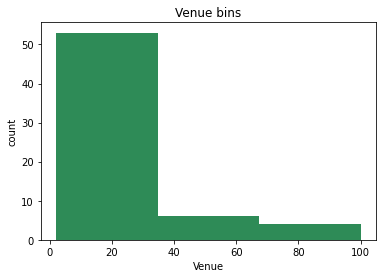

In [31]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot


plt.pyplot.hist(asuncion_g1["Venue"], color = 'seagreen', bins = 3)

# set x/y labels and plot title
plt.pyplot.xlabel("Venue")
plt.pyplot.ylabel("count")
plt.pyplot.title("Venue bins")

#### It can be noticed that the distrbution of venues in Asuncion is quite skewed, where more than 50 neighborhoods have less than 34 venues. Seeing this it can be said that that if you are someone who really need to go out in Asuncion there a few neighborhoods with lot of options 

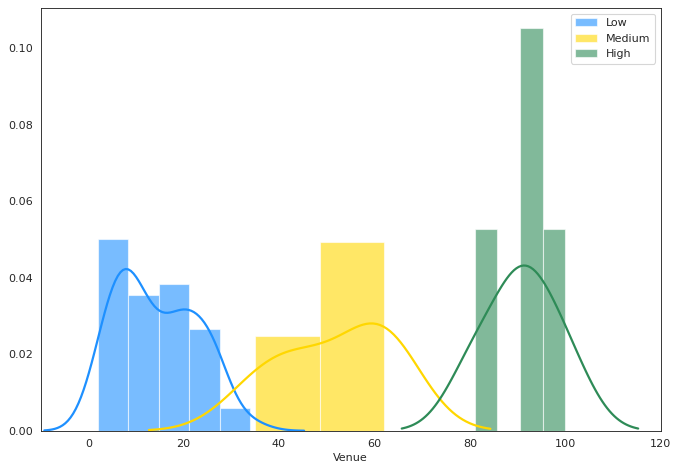

In [32]:
sns.set_style("white")

xx1 = asuncion_g1.loc[asuncion_g1.Venue_Density=='Low', 'Venue']
xx2 = asuncion_g1.loc[asuncion_g1.Venue_Density=='Medium', 'Venue']
xx3 = asuncion_g1.loc[asuncion_g1.Venue_Density=='High', 'Venue']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.pyplot.figure(figsize=(10,7), dpi= 80)
sns.distplot(xx1, color="dodgerblue", label="Low", **kwargs)
sns.distplot(xx2, color="gold", label="Medium", **kwargs)
sns.distplot(xx3, color="seagreen", label="High", **kwargs)
plt.pyplot.xlim(-10,120)
plt.pyplot.legend();

#### Looking the distribution in each bin it seems that in the low density neighborhoods is more evenly distributed the quantity of venues than in the other two categories, so if you choose to stay in one of the neighborhoods with less venues you probably won't notice that much difference with most of the neighborhoods in the same category

#### Now lets see hoy many unique type of venues there is in Asuncion

In [33]:
print('There are {} uniques categories.'.format(len(asuncion_venues['Venue Category'].unique())))

There are 225 uniques categories.


#### Ok that's a number I wasn't expecting, it seems that even that in most neighborhood there is not many venues, in the city there is a lot of thing to try and as the city is not that big you can go to these unique places in relatively short time

#### After that exploratory analysis in that part of the data, I'm going to convert the categorical variables of venues to dummies values so later start to know what kind of vanue are the most common in each neighborhood

In [34]:
# one hot encoding
asuncion_onehot = pd.get_dummies(asuncion_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
asuncion_onehot['Neighborhood'] = asuncion_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [asuncion_onehot.columns[-1]] + list(asuncion_onehot.columns[:-1])
asuncion_onehot = asuncion_onehot[fixed_columns]

asuncion_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Car Wash,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Country Dance Club,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Optical Shop,Other Great Outdoors,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MARISCAL JOSE FELIX ESTIGARRIBIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MARISCAL JOSE FELIX ESTIGARRIBIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [35]:
asuncion_onehot.shape

(1432, 225)

In [36]:
asuncion_grouped = asuncion_onehot.groupby('Neighborhood').mean().reset_index()
asuncion_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Car Wash,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Country Dance Club,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Service,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Venue,Nail Salon,New American Restaurant,Nightclub,Optical Shop,Other Great Outdoors,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Racecourse,Racetrack,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store
0,BELLA VISTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.1,0.0,0.0,0.0,0.100000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.000000,0.0,0.0,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.100000,0.0,0

In [37]:
asuncion_grouped.shape

(63, 225)

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = asuncion_grouped['Neighborhood']

for ind in np.arange(asuncion_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(asuncion_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BELLA VISTA,Plaza,Deli / Bodega,Breakfast Spot,Brewery,Burger Joint,Theme Park,Dive Bar,Toy / Game Store,Fish & Chips Shop,Cosmetics Shop
1,BOTANICO,Pier,Boat or Ferry,Restaurant,Burger Joint,Café,Women's Store,Dive Bar,Farmers Market,Fabric Shop,Event Space
2,CAÑADA DEL YBYRAY,Electronics Store,Ice Cream Shop,Plaza,Austrian Restaurant,Food Court,Burger Joint,Forest,Gas Station,Spa,Pizza Place
3,CIUDAD NUEVA,Chinese Restaurant,Fast Food Restaurant,Gastropub,Asian Restaurant,Breakfast Spot,Ice Cream Shop,Spa,Dessert Shop,Beer Store,Korean Restaurant
4,DE LA RESIDENTA,Burger Joint,Department Store,Pharmacy,BBQ Joint,Massage Studio,Pedestrian Plaza,Supermarket,Market,Auto Garage,Paper / Office Supplies Store


#### So what is the most common venue in all of the neighborhood

In [40]:
neighborhoods_venues_sorted['1st Most Common Venue'].value_counts().to_frame()

,1st Most Common Venue
Pizza Place,8
Fast Food Restaurant,6
Burger Joint,6
Bar,5
Ice Cream Shop,5
Restaurant,4
Athletics & Sports,2
Hotel,2
Plaza,2
Brewery,2


We can see that in 8 neighborhoods the most common venue is a Pizza Place, so if you are looking a place where to try different ingrendients on your pizza the hunting for a neighborhood where to rent it would take longer than for example if you are someone who likes chinese or korean restaurant that just have 1 neighborhood each where the most common place is these kind of venue

## Time to use some algorithms

As the data we've using did not have that much of variables than the venues, venues categories and location of neighborhood, we can't predict where will be a nice place to rent in asuncion, but we've already have pretty good look of how many thing we have to do in each neighborhood and we've could start a model to group neighborhoods in cluster so we know wich one more alike and do not waste time going to neighborhoods that don't fit are needs or preferences.

According to our dataset, the previous analysis that we did and the problem we are trying to solve, we can agree that for this part of the project a classification algorithm would be a great solution, so in order to acchieve this we are choosing to classify the neighborhoods using KMeans

In [41]:
# set number of clusters
kclusters = 8

asuncion_grouped_clustering = asuncion_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(asuncion_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 5, 7, 1, 5, 1], dtype=int32)

In [42]:
df_as.rename(columns = {'barlo_desc':'Neighborhood'}, inplace = True)

df_as.head()

,distrito,dpto_desc,dist_desc,bar_loc,Neighborhood,cant_viv,Adress,location,point,latitude,longitude,altitude
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA...","(Mariscal Jose Felix Estigarribia, Bernardino ...","(-25.2959236, -57.6081948, 0.0)",-25.295924,-57.608195,0.0
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY","(Vista Alegre, Asunción, Región Oriental, 0013...","(-25.3144278, -57.6031993, 0.0)",-25.314428,-57.603199,0.0
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY","(Los Laureles, Asunción, Región Oriental, Para...","(-25.3113548, -57.5770067, 0.0)",-25.311355,-57.577007,0.0
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY","(Villa Morra, Asunción, Región Oriental, Parag...","(-25.2880157, -57.5806859, 0.0)",-25.288016,-57.580686,0.0
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY","(Manorá, Asunción, Región Oriental, 1766, Para...","(-25.284279, -57.5726586, 0.0)",-25.284279,-57.572659,0.0


In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

asuncion_merged = df_as

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
asuncion_merged = asuncion_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

asuncion_merged.head()

,distrito,dpto_desc,dist_desc,bar_loc,Neighborhood,cant_viv,Adress,location,point,latitude,longitude,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
720,0,ASUNCION,ASUNCION,43,MARISCAL JOSE FELIX ESTIGARRIBIA,2192,"MARISCAL JOSE FELIX ESTIGARRIBIA, ASUNCION, PA...","(Mariscal Jose Felix Estigarribia, Bernardino ...","(-25.2959236, -57.6081948, 0.0)",-25.295924,-57.608195,0.0,1.0,Bar,Hotel,Café,Department Store,Breakfast Spot,South American Restaurant,Bookstore,Fast Food Restaurant,Ice Cream Shop,Dessert Shop
722,0,ASUNCION,ASUNCION,17,VISTA ALEGRE,3906,"VISTA ALEGRE, ASUNCION, PARAGUAY","(Vista Alegre, Asunción, Región Oriental, 0013...","(-25.3144278, -57.6031993, 0.0)",-25.314428,-57.603199,0.0,7.0,Pizza Place,Speakeasy,Food Court,Empanada Restaurant,Buffet,Burger Joint,Dive Bar,Farmers Market,Fabric Shop,Event Space
1720,0,ASUNCION,ASUNCION,39,LOS LAURELES,979,"LOS LAURELES, ASUNCION, PARAGUAY","(Los Laureles, Asunción, Región Oriental, Para...","(-25.3113548, -57.5770067, 0.0)",-25.311355,-57.577007,0.0,1.0,Fast Food Restaurant,Burger Joint,Plaza,Shopping Mall,Electronics Store,Food Truck,Bakery,Food & Drink Shop,Design Studio,Boutique
1721,0,ASUNCION,ASUNCION,42,VILLA MORRA,1066,"VILLA MORRA, ASUNCION, PARAGUAY","(Villa Morra, Asunción, Región Oriental, Parag...","(-25.2880157, -57.5806859, 0.0)",-25.288016,-57.580686,0.0,1.0,Ice Cream Shop,Bar,Coffee Shop,Italian Restaurant,Burger Joint,Cosmetics Shop,Spa,Japanese Restaurant,Gym / Fitness Center,South American Restaurant
1722,0,ASUNCION,ASUNCION,58,MANORA,502,"MANORA, ASUNCION, PARAGUAY","(Manorá, Asunción, Región Oriental, 1766, Para...","(-25.284279, -57.5726586, 0.0)",-25.284279,-57.572659,0.0,1.0,Bar,Restaurant,Fast Food Restaurant,Department Store,Clothing Store,Beer Bar,Café,Deli / Bodega,Ice Cream Shop,Food Truck


In [44]:
asuncion_merged.dropna(subset =['Cluster Labels'], inplace = True)
asuncion_merged.shape

(65, 23)

In [45]:
asuncion_merged = asuncion_merged.astype({'Cluster Labels': int})

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(asuncion_merged['latitude'], asuncion_merged['longitude'], asuncion_merged['Neighborhood'], asuncion_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
asuncion_merged.shape

(65, 23)

#### Examinate the clusters of neighborhoods

In [48]:
cluster_asuncion = asuncion_merged[['Neighborhood','Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']]

cluster_asuncion = cluster_asuncion.groupby('Cluster Labels')

cluster_asuncion.first()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Cluster Labels,,,,,,
0,SANTA LIBRADA,Convenience Store,BBQ Joint,Country Dance Club,Coworking Space,Fish & Chips Shop
1,MARISCAL JOSE FELIX ESTIGARRIBIA,Bar,Hotel,Café,Department Store,Breakfast Spot
2,SAN BLAS,Plaza,Park,Gym / Fitness Center,Diner,Farmers Market
3,JUKYTY,Health & Beauty Service,Beach,Women's Store,Dive Bar,Fish & Chips Shop
4,LOMA PYTA,Golf Course,Trail,Women's Store,Discount Store,Fast Food Restaurant
5,GENERAL JOSE EDUVIGIS DIAZ,Park,Women's Store,Auto Garage,Hotel,Ice Cream Shop
6,TABLADA NUEVA,Brewery,Soccer Field,Mobile Phone Shop,Women's Store,Dog Run
7,VISTA ALEGRE,Pizza Place,Speakeasy,Food Court,Empanada Restaurant,Buffet


In [49]:
cluster_asuncion.get_group(0)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7689,SANTA LIBRADA,Convenience Store,BBQ Joint,Country Dance Club,Coworking Space,Fish & Chips Shop


This first cluster have just one neighborhood and have as the most common venue convenience store and as second most common BBQ joint, the most common venue is an useful one when you are looking to rent because it is good to have one near you place.

In [50]:
cluster_asuncion.get_group(1).shape

(46, 6)

In [51]:
cluster_asuncion.get_group(1).head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
720,MARISCAL JOSE FELIX ESTIGARRIBIA,Bar,Hotel,Café,Department Store,Breakfast Spot
1720,LOS LAURELES,Fast Food Restaurant,Burger Joint,Plaza,Shopping Mall,Electronics Store
1721,VILLA MORRA,Ice Cream Shop,Bar,Coffee Shop,Italian Restaurant,Burger Joint
1722,MANORA,Bar,Restaurant,Fast Food Restaurant,Department Store,Clothing Store
1727,BOTANICO,Pier,Boat or Ferry,Restaurant,Burger Joint,Café
1728,ZEBALLOS CUE,Burger Joint,Convenience Store,Country Dance Club,American Restaurant,Shipping Store
1731,LAS MERCEDES,Gym / Fitness Center,Electronics Store,Basketball Stadium,Department Store,Spa
2458,TEMBETARY,Clothing Store,Buffet,Tennis Stadium,Bed & Breakfast,Restaurant
2462,ITA PYTA PUNTA,Fast Food Restaurant,Historic Site,Gym / Fitness Center,Palace,Discount Store
5481,SANTISIMA TRINIDAD,Burger Joint,Pizza Place,Fast Food Restaurant,Soccer Stadium,Shopping Mall


This is the cluster with the most neighborhoods, so probably will end up looking places in one of them and is the one were the most common venues are Fast Food Restaurant, Burger Joint and Bars, so it pretty much solve cooking problems

In [52]:
cluster_asuncion.get_group(2).shape

(1, 6)

In [53]:
cluster_asuncion.get_group(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7663,SAN BLAS,Plaza,Park,Gym / Fitness Center,Diner,Farmers Market


This cluster seem a good option for someone who likes a fitness life, that is good thing but left out other important things

In [54]:
cluster_asuncion.get_group(3).shape

(1, 6)

In [55]:
cluster_asuncion.get_group(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7707,JUKYTY,Health & Beauty Service,Beach,Women's Store,Dive Bar,Fish & Chips Shop


The cluster seems a nice to dedicate to yourself as it contains as most common venue health & beauty services and beach, but it doesn't seem as a place to start renting if you are young 

In [56]:
cluster_asuncion.get_group(4).shape

(1, 6)

The fifth cluster looks a great place to go shopping and take and advantage of sales and also have fast food as a common venue. But it leave of us without a place to buy diary stuff

In [57]:
cluster_asuncion.get_group(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7656,LOMA PYTA,Golf Course,Trail,Women's Store,Discount Store,Fast Food Restaurant


In [58]:
cluster_asuncion.get_group(5).shape

(3, 6)

This cluster have neighborhoods to pick an seems to be a nice place for a tourist as it have parks, hotels, stores, ice cream shop, stadium as most common places, great place to take a foreign friend but still no so much options for renting

In [59]:
cluster_asuncion.get_group(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7631,GENERAL JOSE EDUVIGIS DIAZ,Park,Women's Store,Auto Garage,Hotel,Ice Cream Shop
7640,ÑU GUASU,Soccer Stadium,Chinese Restaurant,Burger Joint,Park,Women's Store
7674,DR FRANCIA,Park,Women's Store,Auto Garage,Hotel,Ice Cream Shop


In [60]:
cluster_asuncion.get_group(6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7684,TABLADA NUEVA,Brewery,Soccer Field,Mobile Phone Shop,Women's Store,Dog Run


This cluster just have one neighborhood and the five most common venues don't meet the criteria for a renting place for a young adult

In [61]:
cluster_asuncion.get_group(7)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
722,VISTA ALEGRE,Pizza Place,Speakeasy,Food Court,Empanada Restaurant,Buffet
7535,LUIS ALBERTO DE HERRERA,Pizza Place,Spa,Bridal Shop,Athletics & Sports,Italian Restaurant
7623,REPUBLICANO,Pizza Place,Pharmacy,Soccer Field,Convenience Store,Liquor Store
7637,SALVADOR DEL MUNDO,Pizza Place,Soccer Field,Burger Joint,Recreation Center,Fast Food Restaurant
7638,SANTA MARIA,Fast Food Restaurant,Coffee Shop,Pizza Place,Food Truck,New American Restaurant
7649,MBOCAYATY,Pizza Place,Gym,Bridal Shop,Food Truck,Burger Joint
7650,MADAME ELISA ALICIA LINCH,Pizza Place,Bookstore,Fast Food Restaurant,Auto Garage,Bakery
7653,SAJONIA,Pizza Place,Soccer Stadium,Trail,Massage Studio,Supermarket
7661,DR ROBERTO L PETTIT,Public Art,Fast Food Restaurant,Ice Cream Shop,Burger Joint,Stadium
7664,SAJONIA,Pizza Place,Soccer Stadium,Trail,Massage Studio,Supermarket


This last cluster seems the group of neighborhood with the just enough pizza places for a pizza fan and have also variaty of other restaurants

## Second Part of the renting hunting analysis. Lets add more variables

Venues options are great for deciding for a place but we need to adapt those preferences to the market option and the prices of that market. To solve this new situation we are going to scrappe one of the most popular website of the country to look for houses or renting one.

The data we are obtaining is from the Infocasas.com.py website and for the scrapping part we've needed to inspect the data of the useful fields for our analysis. Looking for those we found a really good that contain a list of dictionary with all the relevant data from the resuts of the renting search.

Lets define our functions and loop to scrap each result page from the search until the 1=0th page, that would give 900 observations considering that per page the output of the search is 30 renting options

In [62]:
from urllib.request import urlopen,Request

import time

def get_headers():
    #Headers
    headers={'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'accept-language':'en-US,en;q=0.9',
            'cache-control':'max-age=0',
            'upgrade-insecure-requests':'1',
            'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36'}

    return headers







In [63]:
loaded2 = False
try:
    with open('infocasas_raw.pkl', 'rb') as f:
        data_prop_ic = pickle.load(f)
    with open('infocasas_raw1.pkl', 'rb') as f:
        data_prop = pickle.load(f)
    print('infocasas data loaded.')
    loaded2 = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded2:
    
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    count=1 # for pagination

    data_prop=[]
    urls = ["https://www.infocasas.com.py/alquiler/inmuebles/asuncion/"]
    for x in urls:
        count=1
        y=x
        while(count < 31):  # will go till 30 pages
            print(x)
            req = Request(x, headers=get_headers())  #req all headers
            htmlfile = urlopen(req)
            htmltext = htmlfile.read()
            #print (htmltext)
            soup = BS(htmltext,'html.parser')
            #print (soup.prettify())
       
            for tag in soup.findAll('div',attrs={'id':'datos-prop'}): #gets data prop
                    row = tag.get_text()
                    if not row:
                        row="NA"
                    print(row)
                    data_prop.append(row)
               
       
            count=count+1
            page='pagina'+str(count)  # changes page,will go till page 11,total 120 links per city
            x=y+page
    
        time.sleep(3)
    data_prop_ic = pd.DataFrame(list(zip(data_prop)),columns=["Data_prop"])
    
    # Let's persists this in local file system
    with open('infocasas_raw.pkl', 'wb') as f:
        pickle.dump(data_prop_ic, f)
    with open('infocasas_raw1.pkl', 'wb') as f:
        pickle.dump(data_prop, f)


data_prop_ic

infocasas data loaded.


,Data_prop
0,"{""propiedades"":[{""id"":""186492283"",""link"":""alqu..."
1,"{""propiedades"":[{""id"":""186452538"",""link"":""1-do..."
2,"{""propiedades"":[{""id"":""186161989"",""link"":""dpto..."
3,"{""propiedades"":[{""id"":""186021955"",""link"":""herm..."
4,"{""propiedades"":[{""id"":""186502846"",""link"":""loca..."
5,"{""propiedades"":[{""id"":""186064480"",""link"":""exce..."
6,"{""propiedades"":[{""id"":""186306200"",""link"":""ofer..."
7,"{""propiedades"":[{""id"":""186357360"",""link"":""herm..."
8,"{""propiedades"":[{""id"":""186022648"",""link"":""alqu..."
9,"{""propiedades"":[{""id"":""185794607"",""link"":""alqu..."


In [64]:
data_prop_ic.shape

(30, 1)

Inspect our new dataframe from our scrapping we got a column with 10 features, that does not seems right. That because we are dealing json type of data, so in order to convert to an useful dataframe we first will load each row and append to a new list and the convert each list of dictionary to a dataframe

In [65]:
rows1 = []

for data in data_prop:
    data_row = json.loads(data)
    rows1.append(data_row)
 

test_rw1 = pd.DataFrame(rows1)

test_rw1.head(31)

,propiedades
0,"[{'id': '186492283', 'link': 'alquil-dpto-amob..."
1,"[{'id': '186452538', 'link': '1-dormitorio-amo..."
2,"[{'id': '186161989', 'link': 'dpto-de-1-dormit..."
3,"[{'id': '186021955', 'link': 'hermoso-departam..."
4,"[{'id': '186502846', 'link': 'local-comercial-..."
5,"[{'id': '186064480', 'link': 'excelente-depart..."
6,"[{'id': '186306200', 'link': 'oferta-alquiler-..."
7,"[{'id': '186357360', 'link': 'hermoso-departam..."
8,"[{'id': '186022648', 'link': 'alquilo-departam..."
9,"[{'id': '185794607', 'link': 'alquil-dpto-amob..."


In [66]:
rows2 = []

for data in rows1:
    
    data_row = data['propiedades']
    
    for row in data_row:
        
        rows2.append(row)


In [67]:
df_ic = pd.DataFrame(rows2)

df_ic.head(60)

,id,link,zona,img,tipoPropiedad,tipoListing,precio,preciohasta,preciodesde,m2,dormitorios,dormitoriosTXT,banios,baniosTXT,lat,lng,pointType,unidades
0,186492283,alquil-dpto-amoblado-moderno-edif-sky-tower/18...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/14563f9...,Departamentos,0,U$S 2.100,U$S 2.100,U$S 2.100,210,3,Dormitorios,3+,Baños,-25.28774574234691400000,-57.55656838417054000000,0,[]
1,186202173,alquilo-dpto-anmoblado-y-equipado-micro-centro...,Asunción,https://cdn1.infocasas.com.uy/repo/img/4c731f8...,Departamentos,0,Gs. 3.500.000,Gs. 3.500.000,Gs. 3.500.000,1,2,Dormitorios,1,Baño,-25.26813897483510700000,-57.57505416870118000000,1,[]
2,186526363,alquilo-hermoso-dpto-zona-colegio-frances/1865...,Barrio Jara,https://cdn1.infocasas.com.uy/repo/img/3275d02...,Departamentos,0,Gs. 4.200.000,Gs. 4.200.000,Gs. 4.200.000,65,2,Dormitorios,3+,Baños,-25.27780140000000000000,-57.60544160000000000000,0,[]
3,186519490,alquilo-departamento-1-dormitorio-amoblado/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/b51018b...,Departamentos,0,U$S 650,U$S 650,U$S 650,48,1,Dormitorio,1,Baño,-23.31659350000000000000,-58.16934450000000000000,0,[]
4,186197881,alquilo-departamento-de-2-dormitorios-zona-pas...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/41d08ed...,Departamentos,0,Gs. 5.800.000,Gs. 5.800.000,Gs. 5.800.000,110,2,Dormitorios,3+,Baños,-25.28295348513768000000,-57.56197035312653000000,0,[]
5,186532322,inmejorable-ubicacin-de-local-en-comercial/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/c9b72a2...,Locales Comerciales,0,Gs. 6.600.000,Gs. 6.600.000,Gs. 6.600.000,70,4,Ambientes,2,Baños,-23.31659350000000000000,-58.16934450000000000000,0,[]
6,186106531,alquilo-departamento-de-1-dormitorio-completam...,Mburucuyá,https://cdn1.infocasas.com.uy/repo/img/59a5766...,Departamentos,0,U$S 800,U$S 800,U$S 800,58,1,Dormitorio,1,Baño,-25.26499538840837000000,-57.57112741470337600000,0,[]
7,177916,alquilo-hermoso-departamento-amoblado-en-torre...,Mburucuyá,https://cdn1.infocasas.com.uy/repo/img/3250a21...,Departamentos,0,U$S 1.200,U$S 1.200,U$S 1.200,87,2,Dormitorios,2,Baños,-25.26495657819069000000,-57.57121324539184600000,0,[]
8,177909,alquiler-coqueto-departamento-de-3-dormitorios...,Mburucuyá,https://cdn1.infocasas.com.uy/repo/img/8f69540...,Departamentos,0,U$S 1.700,U$S 1.700,U$S 1.700,112,3,Dormitorios,3+,Baños,-25.26489836284093000000,-57.57113277912140000000,0,[]
9,186499256,alquilo-amplio-depto-de-3-dormitorios-sobre-sa...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/537e20b...,Departamentos,0,U$S 2.000,U$S 2.000,U$S 2.000,215,3,Dormitorios,3+,Baños,-25.28649434122080600000,-57.55868196487427500000,0,[]


Now we are going to inspect this new dataframe size

In [68]:
df_ic.shape

(900, 18)

By the results we can say that we accomplish the first step of getting the renting data from the webpage as intended

Now lets examine de data type of each column in the dataframe

In [69]:
df_ic.dtypes

id                object
link              object
zona              object
img               object
tipoPropiedad     object
tipoListing        int64
precio            object
preciohasta       object
preciodesde       object
m2                object
dormitorios       object
dormitoriosTXT    object
banios            object
baniosTXT         object
lat               object
lng               object
pointType         object
unidades          object
dtype: object

As we can see there a lot of object types. So we need to convert the most important ones to the right type in order to using them in our analysis

In [70]:
df_ic['precio'].apply(type).value_counts()

<class 'str'>    900
Name: precio, dtype: int64

Let's start with probably one of the most important, the price column, inspecting that field we notice that there is two kind of currerncies, American Dolar and Paraguayan Guarani and the value contain the currency denominator in the same field. So first we are going to separate the value and the currency in two news columns, because later as we are to use just the Paraguayan Guarani as currency price we need to calculate those USD renting price in Guarani price, so the currency data would be useful for that next step.

In [71]:
df_ic2 = df_ic.copy()

df_ic2[['Moneda','Precio_Origen']] = df_ic2.precio.str.split(expand=True)

df_ic2.head()

,id,link,zona,img,tipoPropiedad,tipoListing,precio,preciohasta,preciodesde,m2,dormitorios,dormitoriosTXT,banios,baniosTXT,lat,lng,pointType,unidades,Moneda,Precio_Origen
0,186492283,alquil-dpto-amoblado-moderno-edif-sky-tower/18...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/14563f9...,Departamentos,0,U$S 2.100,U$S 2.100,U$S 2.100,210,3,Dormitorios,3+,Baños,-25.28774574234691400000,-57.55656838417054000000,0,[],U$S,2.100
1,186202173,alquilo-dpto-anmoblado-y-equipado-micro-centro...,Asunción,https://cdn1.infocasas.com.uy/repo/img/4c731f8...,Departamentos,0,Gs. 3.500.000,Gs. 3.500.000,Gs. 3.500.000,1,2,Dormitorios,1,Baño,-25.26813897483510700000,-57.57505416870118000000,1,[],Gs.,3.500.000
2,186526363,alquilo-hermoso-dpto-zona-colegio-frances/1865...,Barrio Jara,https://cdn1.infocasas.com.uy/repo/img/3275d02...,Departamentos,0,Gs. 4.200.000,Gs. 4.200.000,Gs. 4.200.000,65,2,Dormitorios,3+,Baños,-25.27780140000000000000,-57.60544160000000000000,0,[],Gs.,4.200.000
3,186519490,alquilo-departamento-1-dormitorio-amoblado/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/b51018b...,Departamentos,0,U$S 650,U$S 650,U$S 650,48,1,Dormitorio,1,Baño,-23.31659350000000000000,-58.16934450000000000000,0,[],U$S,650
4,186197881,alquilo-departamento-de-2-dormitorios-zona-pas...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/41d08ed...,Departamentos,0,Gs. 5.800.000,Gs. 5.800.000,Gs. 5.800.000,110,2,Dormitorios,3+,Baños,-25.28295348513768000000,-57.56197035312653000000,0,[],Gs.,5.800.000


In [72]:
df_ic2.dtypes

id                object
link              object
zona              object
img               object
tipoPropiedad     object
tipoListing        int64
precio            object
preciohasta       object
preciodesde       object
m2                object
dormitorios       object
dormitoriosTXT    object
banios            object
baniosTXT         object
lat               object
lng               object
pointType         object
unidades          object
Moneda            object
Precio_Origen     object
dtype: object

Now lets change the type of the rooms values to float in order to use this variable later

In [73]:
df_ic2["dormitorios"] = df_ic2["dormitorios"].str.replace('+','').astype("float")

df_ic2.head()

,id,link,zona,img,tipoPropiedad,tipoListing,precio,preciohasta,preciodesde,m2,dormitorios,dormitoriosTXT,banios,baniosTXT,lat,lng,pointType,unidades,Moneda,Precio_Origen
0,186492283,alquil-dpto-amoblado-moderno-edif-sky-tower/18...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/14563f9...,Departamentos,0,U$S 2.100,U$S 2.100,U$S 2.100,210,3.0,Dormitorios,3+,Baños,-25.28774574234691400000,-57.55656838417054000000,0,[],U$S,2.100
1,186202173,alquilo-dpto-anmoblado-y-equipado-micro-centro...,Asunción,https://cdn1.infocasas.com.uy/repo/img/4c731f8...,Departamentos,0,Gs. 3.500.000,Gs. 3.500.000,Gs. 3.500.000,1,2.0,Dormitorios,1,Baño,-25.26813897483510700000,-57.57505416870118000000,1,[],Gs.,3.500.000
2,186526363,alquilo-hermoso-dpto-zona-colegio-frances/1865...,Barrio Jara,https://cdn1.infocasas.com.uy/repo/img/3275d02...,Departamentos,0,Gs. 4.200.000,Gs. 4.200.000,Gs. 4.200.000,65,2.0,Dormitorios,3+,Baños,-25.27780140000000000000,-57.60544160000000000000,0,[],Gs.,4.200.000
3,186519490,alquilo-departamento-1-dormitorio-amoblado/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/b51018b...,Departamentos,0,U$S 650,U$S 650,U$S 650,48,1.0,Dormitorio,1,Baño,-23.31659350000000000000,-58.16934450000000000000,0,[],U$S,650
4,186197881,alquilo-departamento-de-2-dormitorios-zona-pas...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/41d08ed...,Departamentos,0,Gs. 5.800.000,Gs. 5.800.000,Gs. 5.800.000,110,2.0,Dormitorios,3+,Baños,-25.28295348513768000000,-57.56197035312653000000,0,[],Gs.,5.800.000


Lets inspect our new column of original price (USD and Gs) so we can know the type of this data

In [74]:
df_ic2['Precio_Origen'].apply(type).value_counts()

<class 'str'>    900
Name: Precio_Origen, dtype: int64

In [75]:
df_ic2['Precio_Origen'].max()

'980.000'

We replace the dot in order to convert the string trype data to float

In [76]:
df_ic2['Precio_Origen'] = df_ic2['Precio_Origen'].str.replace('.','').astype('float')

In [77]:
df_ic2.head()

,id,link,zona,img,tipoPropiedad,tipoListing,precio,preciohasta,preciodesde,m2,dormitorios,dormitoriosTXT,banios,baniosTXT,lat,lng,pointType,unidades,Moneda,Precio_Origen
0,186492283,alquil-dpto-amoblado-moderno-edif-sky-tower/18...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/14563f9...,Departamentos,0,U$S 2.100,U$S 2.100,U$S 2.100,210,3.0,Dormitorios,3+,Baños,-25.28774574234691400000,-57.55656838417054000000,0,[],U$S,2100.0
1,186202173,alquilo-dpto-anmoblado-y-equipado-micro-centro...,Asunción,https://cdn1.infocasas.com.uy/repo/img/4c731f8...,Departamentos,0,Gs. 3.500.000,Gs. 3.500.000,Gs. 3.500.000,1,2.0,Dormitorios,1,Baño,-25.26813897483510700000,-57.57505416870118000000,1,[],Gs.,3500000.0
2,186526363,alquilo-hermoso-dpto-zona-colegio-frances/1865...,Barrio Jara,https://cdn1.infocasas.com.uy/repo/img/3275d02...,Departamentos,0,Gs. 4.200.000,Gs. 4.200.000,Gs. 4.200.000,65,2.0,Dormitorios,3+,Baños,-25.27780140000000000000,-57.60544160000000000000,0,[],Gs.,4200000.0
3,186519490,alquilo-departamento-1-dormitorio-amoblado/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/b51018b...,Departamentos,0,U$S 650,U$S 650,U$S 650,48,1.0,Dormitorio,1,Baño,-23.31659350000000000000,-58.16934450000000000000,0,[],U$S,650.0
4,186197881,alquilo-departamento-de-2-dormitorios-zona-pas...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/41d08ed...,Departamentos,0,Gs. 5.800.000,Gs. 5.800.000,Gs. 5.800.000,110,2.0,Dormitorios,3+,Baños,-25.28295348513768000000,-57.56197035312653000000,0,[],Gs.,5800000.0


In [78]:
df_ic2['Precio_Origen'].apply(type).value_counts()

<class 'float'>    900
Name: Precio_Origen, dtype: int64

Now that we know that this field has the right data type we are going to inspect how many features of each currency we have, just to make sure if we need to convert the data or just drop it.

In [79]:
df_ic2.groupby(['Moneda'])['Moneda'].count()

Moneda
Gs.    569
U$S    331
Name: Moneda, dtype: int64

Ok, the data is really split so we've confirmed that we need to convert de USD rent prices to Gs price, so we create a new calculated column multiplying each USD price observation by the equivalent of Guaranies per Dolar

In [80]:
Dolar = 6850
df_ic2 ['Precio_Gs'] = np.where(df_ic2.Moneda == 'U$S', df_ic2.Precio_Origen * Dolar, df_ic2.Precio_Origen)

In [81]:
df_ic2.head()

,id,link,zona,img,tipoPropiedad,tipoListing,precio,preciohasta,preciodesde,m2,dormitorios,dormitoriosTXT,banios,baniosTXT,lat,lng,pointType,unidades,Moneda,Precio_Origen,Precio_Gs
0,186492283,alquil-dpto-amoblado-moderno-edif-sky-tower/18...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/14563f9...,Departamentos,0,U$S 2.100,U$S 2.100,U$S 2.100,210,3.0,Dormitorios,3+,Baños,-25.28774574234691400000,-57.55656838417054000000,0,[],U$S,2100.0,14385000.0
1,186202173,alquilo-dpto-anmoblado-y-equipado-micro-centro...,Asunción,https://cdn1.infocasas.com.uy/repo/img/4c731f8...,Departamentos,0,Gs. 3.500.000,Gs. 3.500.000,Gs. 3.500.000,1,2.0,Dormitorios,1,Baño,-25.26813897483510700000,-57.57505416870118000000,1,[],Gs.,3500000.0,3500000.0
2,186526363,alquilo-hermoso-dpto-zona-colegio-frances/1865...,Barrio Jara,https://cdn1.infocasas.com.uy/repo/img/3275d02...,Departamentos,0,Gs. 4.200.000,Gs. 4.200.000,Gs. 4.200.000,65,2.0,Dormitorios,3+,Baños,-25.27780140000000000000,-57.60544160000000000000,0,[],Gs.,4200000.0,4200000.0
3,186519490,alquilo-departamento-1-dormitorio-amoblado/186...,Villa Morra,https://cdn1.infocasas.com.uy/repo/img/b51018b...,Departamentos,0,U$S 650,U$S 650,U$S 650,48,1.0,Dormitorio,1,Baño,-23.31659350000000000000,-58.16934450000000000000,0,[],U$S,650.0,4452500.0
4,186197881,alquilo-departamento-de-2-dormitorios-zona-pas...,Ycuá Satí,https://cdn1.infocasas.com.uy/repo/img/41d08ed...,Departamentos,0,Gs. 5.800.000,Gs. 5.800.000,Gs. 5.800.000,110,2.0,Dormitorios,3+,Baños,-25.28295348513768000000,-57.56197035312653000000,0,[],Gs.,5800000.0,5800000.0


In [82]:
df_ic2['Precio_Gs'].max()

71925000000.0

In [83]:
df_ic2['m2'].apply(type).value_counts()

<class 'str'>    900
Name: m2, dtype: int64

Let's drop all the column that we are not going to use for the analysis and that not contain important data, such the id, link, image, the description of rooms and bathrooms, the original price, the columns of price from and until

In [84]:
df_ic2.drop(['unidades'], axis=1, inplace = True)

In [85]:
df_ic2.drop(['link','img','tipoListing','precio','preciohasta','preciodesde', 'dormitoriosTXT','baniosTXT'], axis=1, inplace =True)

df_ic2.head()

,id,zona,tipoPropiedad,m2,dormitorios,banios,lat,lng,pointType,Moneda,Precio_Origen,Precio_Gs
0,186492283,Ycuá Satí,Departamentos,210,3.0,3+,-25.28774574234691400000,-57.55656838417054000000,0,U$S,2100.0,14385000.0
1,186202173,Asunción,Departamentos,1,2.0,1,-25.26813897483510700000,-57.57505416870118000000,1,Gs.,3500000.0,3500000.0
2,186526363,Barrio Jara,Departamentos,65,2.0,3+,-25.27780140000000000000,-57.60544160000000000000,0,Gs.,4200000.0,4200000.0
3,186519490,Villa Morra,Departamentos,48,1.0,1,-23.31659350000000000000,-58.16934450000000000000,0,U$S,650.0,4452500.0
4,186197881,Ycuá Satí,Departamentos,110,2.0,3+,-25.28295348513768000000,-57.56197035312653000000,0,Gs.,5800000.0,5800000.0


After we to clean a little bit more our data, so we need to see what kind of property are for renting, taking in account that we only need a house or a department, because we just need to rent a place for living and no for business

In [86]:
df_ic2.groupby(['tipoPropiedad'])['tipoPropiedad'].count()

tipoPropiedad
Casas                  148
Departamentos          587
Dúplex                  78
Edificios u Hoteles      3
Locales Comerciales     35
Oficinas                38
Terrenos                 1
Tinglado o Depósito     10
Name: tipoPropiedad, dtype: int64

In [87]:
df_ic2['tipoPropiedad'] = df_ic2['tipoPropiedad'].astype('str')

In [88]:
df_ic2.groupby(['tipoPropiedad'])['tipoPropiedad'].count()

tipoPropiedad
Casas                  148
Departamentos          587
Dúplex                  78
Edificios u Hoteles      3
Locales Comerciales     35
Oficinas                38
Terrenos                 1
Tinglado o Depósito     10
Name: tipoPropiedad, dtype: int64

In [89]:
df_ic2 = df_ic2.loc[(df_ic2['tipoPropiedad'] == 'Departamentos') | (df_ic2['tipoPropiedad'] == 'Casas')]

df_ic2.groupby(['tipoPropiedad'])['tipoPropiedad'].count()

tipoPropiedad
Casas            148
Departamentos    587
Name: tipoPropiedad, dtype: int64

Now keep going with the cleaning, before we've identified that the m2 field have NA values and as this data is important for later analysis, we have to replace those NA values, so we'll replace them with the mean value

In [90]:
df_ic2['m2'].replace({'N/A': 0}, inplace = True)
avg_m2 = df_ic2['m2'].astype('float').mean(axis=0)
print ("Average of m2", avg_m2)

Average of m2 147.2739306122449


In [91]:
df_ic2['m2'].replace({0: avg_m2}, inplace = True)

df_ic2['m2'].head()

0    210.0
1      1.0
2     65.0
3     48.0
4    110.0
Name: m2, dtype: float64

In [92]:
df_ic2['m2'].apply(type).value_counts()

<class 'float'>    735
Name: m2, dtype: int64

After that let's take a look to the neighborhood to see if there is some neighborhood that does not belong to Asuncion

In [93]:
df_ic2.groupby(['zona'])['zona'].count()

zona
Asunción                  56
Barrio Jara               37
Bella Vista                4
Bernardino Caballero       3
Botánico                   1
Catedral                  21
Ciudad Nueva              16
De las Residentas          1
Dr. Francia                1
Gral. Diaz                12
Herrera                   33
Hipódromo                  2
Itá Enramada               3
La Encarnación             2
Las Carmelitas            43
Las Lomas                  9
Las Mercedes              34
Loma Pytá                  1
Los Laureles              11
Manorá                    28
Mbocayaty                  4
Mburicaó                  11
Mburucuyá                 69
Mcal. Estigarribia        15
Mcal. López                8
Mme. Lynch                 4
Nazareth                   2
Obrero                     3
Pettirossi                 7
Pinozá                     3
Recoleta                  17
Republicano                2
Sajonia                   11
Salvador del Mundo         3
San Crist

As it seems that in the neighborhood part of the data it's everything ok, let's continue with data-wrangling, converting the bathroom data to the proper type

In [94]:
df_ic2["banios"] = df_ic2["banios"].str.replace('+','').astype("float")

In [95]:
df_ic2.shape

(735, 12)

So after that cleaning what about if we start looking some descriptive statitics and see if there is something we need to get right in the data in order to start analyzing it

In [96]:
df_ic2.describe()

,m2,dormitorios,banios,Precio_Origen,Precio_Gs
count,735.000000,735.000000,735.000000,7.350000e+02,7.350000e+02
mean,147.474303,2.080272,2.008163,2.383541e+06,1.267779e+07
std,140.279730,1.142601,0.846495,2.649216e+06,1.075939e+08
min,1.000000,0.000000,1.000000,3.500000e+01,2.397500e+05
25%,60.000000,1.000000,1.000000,1.800000e+03,3.000000e+06
50%,98.000000,2.000000,2.000000,2.100000e+06,5.000000e+06
75%,180.000000,3.000000,3.000000,3.650000e+06,8.905000e+06
max,900.000000,5.000000,3.000000,2.500000e+07,2.397500e+09


In [97]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

df_ic2.describe(include='all')

,id,zona,tipoPropiedad,m2,dormitorios,banios,lat,lng,pointType,Moneda,Precio_Origen,Precio_Gs
count,735,735,735,735,735,735,735,735,735,735,735,735
unique,735,49,2,nan,nan,nan,545,548,2,2,nan,nan
top,186412817,Ycuá Satí,Departamentos,nan,nan,nan,-23.31659350000000000000,-58.16934450000000000000,0,Gs.,nan,nan
freq,1,104,587,nan,nan,nan,23,23,389,445,nan,nan
mean,NaN,NaN,NaN,147,2,2,NaN,NaN,NaN,NaN,2383541,12677793
std,NaN,NaN,NaN,140,1,1,NaN,NaN,NaN,NaN,2649216,107593919
min,NaN,NaN,NaN,1,0,1,NaN,NaN,NaN,NaN,35,239750
25%,NaN,NaN,NaN,60,1,1,NaN,NaN,NaN,NaN,1800,3000000
50%,NaN,NaN,NaN,98,2,2,NaN,NaN,NaN,NaN,2100000,5000000
75%,NaN,NaN,NaN,180,3,3,NaN,NaN,NaN,NaN,3650000,8905000


We can see that in the field dormitorios that contains the quantity of rooms have a minimun of 0, that is not ok as how coould exists a place with no rooms, so in order to replace those rows with data, we are going to find what the quantity of rooms that it is most repeated on our data

In [98]:
df_ic2['dormitorios'].value_counts().idxmax()

2.0

In [99]:
df_ic2['dormitorios'].replace(0, 2, inplace=True)

In [100]:
df_ic2.describe()

,m2,dormitorios,banios,Precio_Origen,Precio_Gs
count,735,735,735,735,735
mean,147,2,2,2383541,12677793
std,140,1,1,2649216,107593919
min,1,1,1,35,239750
25%,60,2,1,1800,3000000
50%,98,2,2,2100000,5000000
75%,180,3,3,3650000,8905000
max,900,5,3,25000000,2397500000


## Exploratory analysis of renting data

First we are going to group in bins the prices in Low, Medium and High, to see how it is distributed the prices of renting

In [101]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
bins = np.linspace(min(df_ic2["Precio_Gs"]), max(df_ic2["Precio_Gs"]), 4)
bins

array([2.39750000e+05, 7.99326500e+08, 1.59841325e+09, 2.39750000e+09])

In [102]:
group_names1 = ['Low', 'Medium', 'High']

df_ic2['Price_binned'] = pd.cut(df_ic2['Precio_Gs'], bins, labels = group_names1, include_lowest= True)

df_ic2[['Precio_Gs','Price_binned']].head()

,Precio_Gs,Price_binned
0,14385000,Low
1,3500000,Low
2,4200000,Low
3,4452500,Low
4,5800000,Low


In [103]:
df_ic2["Price_binned"].value_counts()

Low       733
High        2
Medium      0
Name: Price_binned, dtype: int64

We can see that there are some outliers in the data that are distorsioning it in just two categories. 
To reduce the quantity of outliers let's create a subset of our data, putting a limit in the price, so considering that we are trying to solve a problem for young people or kind of young people(20 to 29 years), how about Gs 4.000.000 (about USD 580). We know that for the country that is a pretty high limit, but for the sake of no reducing too much our data, let's continue with it.  


Text(0.5, 1.0, 'price bins')

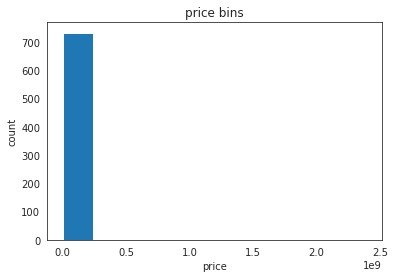

In [104]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot


plt.pyplot.hist(df_ic2["Precio_Gs"])



# set x/y labels and plot title
plt.pyplot.xlabel("price")
plt.pyplot.ylabel("count")
plt.pyplot.title("price bins")

In [105]:
df_ic3 = df_ic2.copy()

df_ic3.drop(['Price_binned'], axis =1, inplace = True)



In [106]:
df_ic3 = df_ic3.loc[(df_ic3['Precio_Gs'] <= 4000000)]

df_ic3.Precio_Gs.max()

4000000.0

Text(0.5, 1.0, 'price bins')

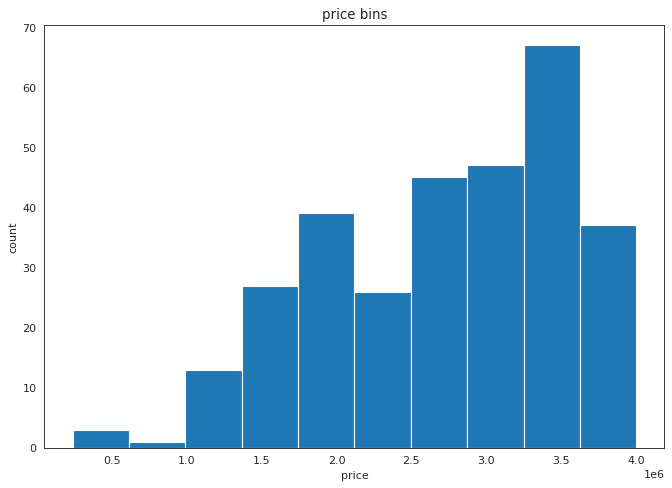

In [107]:
plt.pyplot.figure(figsize=(10,7), dpi= 80)

plt.pyplot.hist(df_ic3["Precio_Gs"])

# set x/y labels and plot title
plt.pyplot.xlabel("price")
plt.pyplot.ylabel("count")
plt.pyplot.title("price bins")


We can see that distribution of the renting prices of our data tendes to be in the highest prices, starting at 2.5000.000. This could be telling us about that is the kind of price we could expect in Asuncion, but also this could be because of the kind of people that offer places through this type of websites.

In [108]:
df_group_one = df_ic3[['tipoPropiedad','Precio_Gs']]

df_group_one.head()

,tipoPropiedad,Precio_Gs
1,Departamentos,3500000
10,Departamentos,2200000
19,Departamentos,3600000
26,Departamentos,3500000
28,Departamentos,3200000


In [109]:
df_group_one = df_group_one.groupby(['tipoPropiedad'], as_index = False).mean()

df_group_one

,tipoPropiedad,Precio_Gs
0,Casas,2881667
1,Departamentos,2714475


After checking the average price by type in the city, we can see that an apartment is in average cheaper than a house but not that by much, just Gs 170.000 that is equal to almost USD 60.

In [110]:
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

df_group_two = df_ic3[['dormitorios','Precio_Gs']]

df_group_two = df_group_two.groupby(['dormitorios'], as_index = False).mean()

df_group_two

,dormitorios,Precio_Gs
0,1.000,"2,763,897.312"
1,2.000,"2,627,169.312"
2,3.000,"3,377,500.000"
3,4.000,"3,600,000.000"


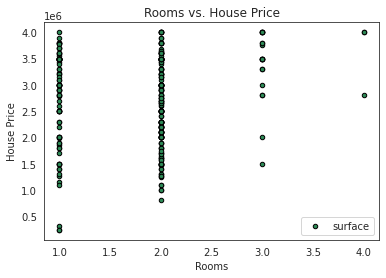

In [111]:
plt.pyplot.figure()
plt.pyplot.scatter(df_ic3['dormitorios'],df_ic3['Precio_Gs'], s=20, edgecolor="black",c="seagreen", label="surface")
plt.pyplot.xlabel("Rooms")
plt.pyplot.ylabel("House Price")
plt.pyplot.title("Rooms vs. House Price")
plt.pyplot.legend()
plt.pyplot.show()

Seeing the average price we can notice that more rooms means highest price, that's quite logical, but doesn't not applied to the one rooms places, that cost in average more than a place with 2 rooms, this is odd but could be because we replaced those observation without rooms with the most common, that was 2 rooms per place

In [112]:
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

df_group_3 = df_ic3[['dormitorios','tipoPropiedad','Precio_Gs']]

df_group_3 = df_group_3.groupby(['tipoPropiedad','dormitorios'], as_index = False).mean()

df_group_3

,tipoPropiedad,dormitorios,Precio_Gs
0,Casas,1.000000,"2,671,428.571429"
1,Casas,2.000000,"2,540,000.000000"
2,Casas,3.000000,"3,360,000.000000"
3,Casas,4.000000,"3,600,000.000000"
4,Departamentos,1.000000,"2,771,423.837209"
5,Departamentos,2.000000,"2,631,527.777778"
6,Departamentos,3.000000,"3,383,333.333333"


Grouping the data by types and quantity of rooms, we can see in terms of rooms it follows the same tendency we saw previously, but interestingly a house with 3 rooms is cheaper than an apartment with the same quantity of rooms. So if you are looking for more rooms probably you can look for a house instead of an apartment

Well know let's see the correlation between our numerical variables and focusing in the correlation with the price

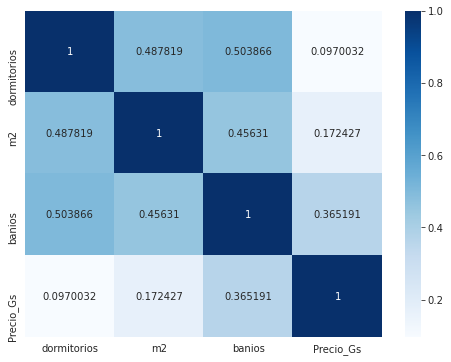

In [113]:
## Just numerical columns
x_cor = df_ic3[['dormitorios','m2','banios','Precio_Gs']]
## correlation matrix
corrMatrix = x_cor.corr()
## correlation matrix in a heatmap

fig, ax = plt.pyplot.subplots(figsize=(8,6))

sns.heatmap(corrMatrix, annot = True, cmap="Blues" ,fmt='g')

plt.pyplot.show()



Looking at the correlation matrix there is no variable with high correlation with price.

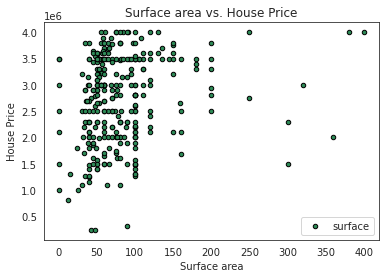

In [114]:
plt.pyplot.figure()
plt.pyplot.scatter(df_ic3['m2'],df_ic3['Precio_Gs'], s=20, edgecolor="black",c="seagreen", label="surface")
plt.pyplot.xlabel("Surface area")
plt.pyplot.ylabel("House Price")
plt.pyplot.title("Surface area vs. House Price")
plt.pyplot.legend()
plt.pyplot.show()

So how about if we get the Foursquare data and combine that data with our renting to add more variables and start preparing for our model

In [115]:
df_ic3 = df_ic3.drop(363)

In [116]:
LIMIT = 100
loadedic = False
try:
    with open('asuncion_venues_ic.pkl', 'rb') as f:
        asuncion_venues_ic = pickle.load(f)
    print('asuncion venues infocasas data loaded.')
    loadedic = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loadedic:
    asuncion_venues_ic = getNearbyVenues(names=df_ic3['id'],
                                   latitudes=df_ic3['lat'],
                                   longitudes=df_ic3['lng']
                                  )
    
    # Let's persists this in local file system
    with open('asuncion_venues_ic.pkl', 'wb') as f:
        pickle.dump(asuncion_venues_ic, f)

asuncion_venues_ic.head()

asuncion venues infocasas data loaded.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,186202173,-25.26813897483510700000,-57.57505416870118000000,Calle 11 Spa Urbano,-25.267271,-57.575896,Spa
1,186202173,-25.26813897483510700000,-57.57505416870118000000,Shoping del Sol,-25.266004,-57.573843,Forest
2,186202173,-25.26813897483510700000,-57.57505416870118000000,Asuncion Lawn Tennis Club,-25.264423,-57.574239,Tennis Stadium
3,186202173,-25.26813897483510700000,-57.57505416870118000000,shopping del sol pizza hut,-25.270367,-57.576344,Food Court
4,186202173,-25.26813897483510700000,-57.57505416870118000000,Autoservice baby,-25.271408,-57.576991,Convenience Store


In [117]:
asuncion_venues_ic.shape

(8892, 7)

In [118]:
# one hot encoding
asuncion_onehot_ic = pd.get_dummies(asuncion_venues_ic[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
asuncion_onehot_ic['Neighborhood'] = asuncion_venues_ic['Neighborhood'] 
asuncion_onehot_ic.head()

,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Farm,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Volcano,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0

In [119]:
asuncion_grouped_ic = asuncion_onehot_ic.groupby('Neighborhood').mean().reset_index()
asuncion_grouped_ic.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Farm,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Volcano,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,185666648,0.000000,0.00

In [120]:
asuncion_grouped_ic.shape

(285, 284)

In [121]:
asuncion_grouped_ic.rename(columns ={'Neighborhood': 'id'}, inplace=True)

asuncion_grouped_ic.head()

,id,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Farm,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Volcano,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,185666648,0.000000,0.000000,0.000

In [122]:
df_ic4 = df_ic3.copy()

df_ic4.head()

,id,zona,tipoPropiedad,m2,dormitorios,banios,lat,lng,pointType,Moneda,Precio_Origen,Precio_Gs
1,186202173,Asunción,Departamentos,1.000000,2.000000,1.000000,-25.26813897483510700000,-57.57505416870118000000,1,Gs.,"3,500,000.000000","3,500,000.000000"
10,186499229,San Roque,Departamentos,120.000000,2.000000,2.000000,-25.29471794438007000000,-57.62894511222840000000,0,Gs.,"2,200,000.000000","2,200,000.000000"
19,186286594,Trinidad,Departamentos,65.000000,2.000000,1.000000,-25.25741725000000300000,-57.57659847770598600000,0,Gs.,"3,600,000.000000","3,600,000.000000"
26,186303039,Asunción,Departamentos,1.000000,1.000000,2.000000,-25.27040713668035500000,-57.55763053894044000000,1,Gs.,"3,500,000.000000","3,500,000.000000"
28,186527510,San Vicente,Departamentos,75.000000,2.000000,2.000000,-25.31049730000000000000,-57.63109390000000000000,0,Gs.,"3,200,000.000000","3,200,000.000000"


In [123]:
dummies = pd.get_dummies(df_ic4.zona, prefix="")
df_ic4 = pd.concat([df_ic4,dummies], axis = 1)
dummies2 = pd.get_dummies(df_ic4.tipoPropiedad, prefix ="")
df_ic4 = pd.concat([df_ic4, dummies2], axis = 1)
dummies3 = pd.get_dummies(df_ic4.Moneda, prefix = "")
df_ic4 = pd.concat([df_ic4, dummies3], axis =1)

del df_ic4['zona']
del df_ic4['tipoPropiedad']
del df_ic4['Moneda']
del df_ic4['lat']
del df_ic4['lng']
del df_ic4['pointType']
del df_ic4['Precio_Origen']

df_ic4.head()





,id,m2,dormitorios,banios,Precio_Gs,_Asunción,_Barrio Jara,_Bernardino Caballero,_Catedral,_Ciudad Nueva,_De las Residentas,_Dr. Francia,_Gral. Diaz,_Herrera,_Hipódromo,_Itá Enramada,_La Encarnación,_Las Carmelitas,_Las Lomas,_Las Mercedes,_Loma Pytá,_Los Laureles,_Manorá,_Mbocayaty,_Mburicaó,_Mburucuyá,_Mcal. Estigarribia,_Mcal. López,_Mme. Lynch,_Nazareth,_Obrero,_Pettirossi,_Pinozá,_Recoleta,_Republicano,_Sajonia,_San Cristobal,_San Jorge,_San Pablo,_San Roque,_San Vicente,_Sta. María,_Tembetary,_Trinidad,_Villa Aurelia,_Villa Morra,_Virgen de la Asunción,_Virgen del Huerto,_Vista Alegre,_Ycuá Satí,_Casas,_Departamentos,_Gs.,_U$S
1,186202173,1.000000,2.000000,1.000000,"3,500,000.000000",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
10,186499229,120.000000,2.000000,2.000000,"2,200,000.000000",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
19,186286594,65.000000,2.000000,1.000000,"3,600,000.000000",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
26,186303039,1.000000,1.000000,2.000000,"3,500,000.000000",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
28,186527510,75.000000,2.000000,2.000000,"3,200,000.000000",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0


In [124]:
asuncion_merged_ic = df_ic4

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
asuncion_merged_ic = asuncion_merged_ic.join(asuncion_grouped_ic.set_index('id'), on='id')

asuncion_merged_ic.head()

,id,m2,dormitorios,banios,Precio_Gs,_Asunción,_Barrio Jara,_Bernardino Caballero,_Catedral,_Ciudad Nueva,_De las Residentas,_Dr. Francia,_Gral. Diaz,_Herrera,_Hipódromo,_Itá Enramada,_La Encarnación,_Las Carmelitas,_Las Lomas,_Las Mercedes,_Loma Pytá,_Los Laureles,_Manorá,_Mbocayaty,_Mburicaó,_Mburucuyá,_Mcal. Estigarribia,_Mcal. López,_Mme. Lynch,_Nazareth,_Obrero,_Pettirossi,_Pinozá,_Recoleta,_Republicano,_Sajonia,_San Cristobal,_San Jorge,_San Pablo,_San Roque,_San Vicente,_Sta. María,_Tembetary,_Trinidad,_Villa Aurelia,_Villa Morra,_Virgen de la Asunción,_Virgen del Huerto,_Vista Alegre,_Ycuá Satí,_Casas,_Departamentos,_Gs.,_U$S,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Farm,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish

In [125]:
asuncion_merged_ic.shape

(304, 337)

In [126]:
asuncion_merged_ic.dropna(subset =['Accessories Store'], inplace = True)
asuncion_merged_ic.shape

(285, 337)

In [127]:
cdf = asuncion_merged_ic.drop('id', axis = 1)
cdf.head(9)

,m2,dormitorios,banios,Precio_Gs,_Asunción,_Barrio Jara,_Bernardino Caballero,_Catedral,_Ciudad Nueva,_De las Residentas,_Dr. Francia,_Gral. Diaz,_Herrera,_Hipódromo,_Itá Enramada,_La Encarnación,_Las Carmelitas,_Las Lomas,_Las Mercedes,_Loma Pytá,_Los Laureles,_Manorá,_Mbocayaty,_Mburicaó,_Mburucuyá,_Mcal. Estigarribia,_Mcal. López,_Mme. Lynch,_Nazareth,_Obrero,_Pettirossi,_Pinozá,_Recoleta,_Republicano,_Sajonia,_San Cristobal,_San Jorge,_San Pablo,_San Roque,_San Vicente,_Sta. María,_Tembetary,_Trinidad,_Villa Aurelia,_Villa Morra,_Virgen de la Asunción,_Virgen del Huerto,_Vista Alegre,_Ycuá Satí,_Casas,_Departamentos,_Gs.,_U$S,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Fabric Shop,Farm,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indie Movie Theater,Indie Theater,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Laundry Service,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Re

In [128]:
msk = np.random.rand(len(asuncion_merged_ic)) < 0.65
train = cdf[msk]
test = cdf[~msk]

In [129]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
target= np.asanyarray(train[['Precio_Gs']])
features = train.drop('Precio_Gs', axis = 1)
features = np.asanyarray(features)

regr.fit (features, target)

print('The R-square is: ', regr.score(features, target))



The R-square is:  0.9609815484676412


In [130]:
from sklearn.metrics import mean_squared_error

ttarget= np.asanyarray(test[['Precio_Gs']])
tfeatures = test.drop('Precio_Gs', axis = 1)
tfeatures = np.asanyarray(tfeatures)

y_hat= regr.predict(tfeatures)

print('The mean square error of price and predicted value using multifit is: ', \
      mean_squared_error(ttarget, y_hat))

# Explained variance score: 1 is perfect prediction
print('The R-square is: ', regr.score(tfeatures, ttarget))

The mean square error of price and predicted value using multifit is:  5556785243963.962
The R-square is:  -7.328907974245105


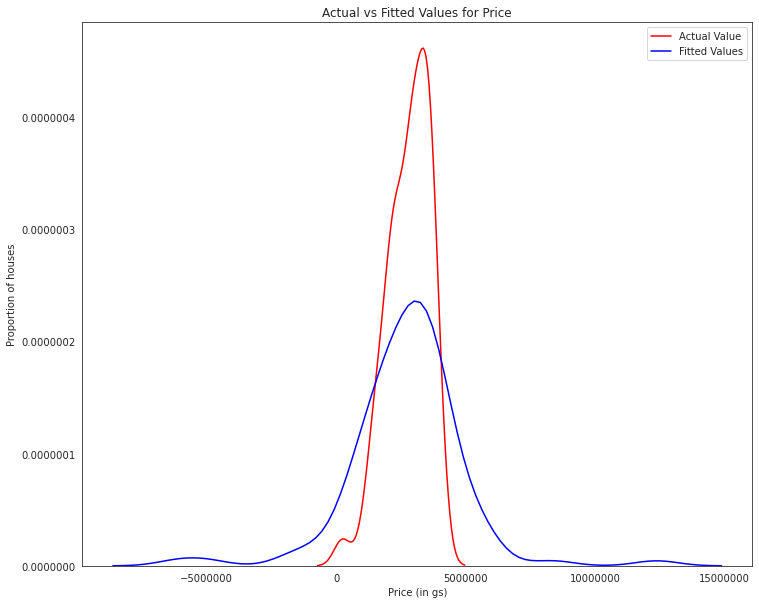

In [131]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
width = 12
height = 10

plt.pyplot.figure(figsize=(width, height))


ax1 = sns.distplot(ttarget, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.pyplot.title('Actual vs Fitted Values for Price')
plt.pyplot.xlabel('Price (in gs)')
plt.pyplot.ylabel('Proportion of houses')
plt.pyplot.ticklabel_format(style='plain')

plt.pyplot.show()
plt.pyplot.close()

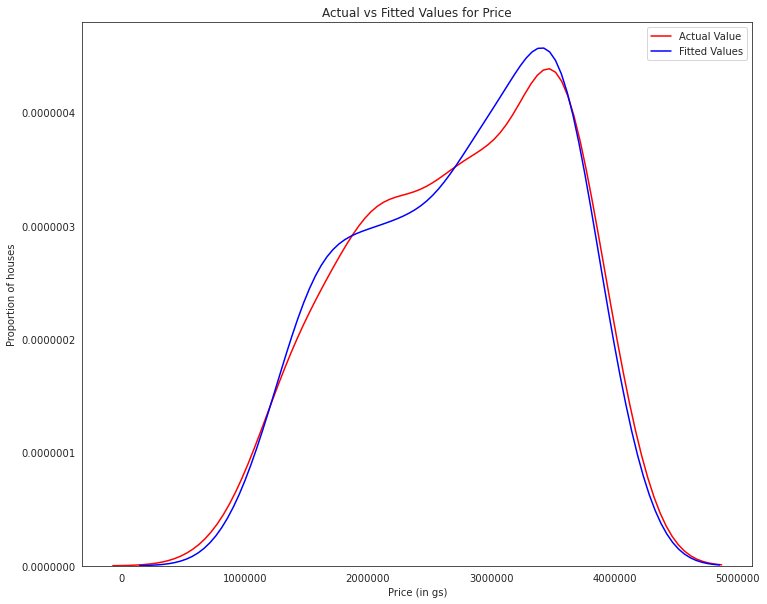

In [132]:
yhat_train = regr.predict(features)

plt.pyplot.figure(figsize=(width, height))


ax1 = sns.distplot(target, hist=False, color="r", label="Actual Value")
sns.distplot(yhat_train, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.pyplot.title('Actual vs Fitted Values for Price')
plt.pyplot.xlabel('Price (in gs)')
plt.pyplot.ylabel('Proportion of houses')
plt.pyplot.ticklabel_format(style='plain')

plt.pyplot.show()
plt.pyplot.close()

In [133]:
y_data = cdf['Precio_Gs']
x_data=cdf.drop('Precio_Gs',axis=1)

from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 129
number of training samples: 156


In [134]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train)
x_test_pr=pr.fit_transform(x_test)

RigeModel=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

RigeModel.fit(x_train_pr, y_train)

yhat = RigeModel.predict(x_test_pr)

print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [2649722.06631636 4178112.83411434 3529030.64029804 4973283.17481741]
test set : [2700000. 4000000. 3150000. 2800000.]


In [135]:
print('The R-square is: ', RigeModel.score(x_test_pr, y_test))
print('The R-square is: ', RigeModel.score(x_train_pr, y_train))

The R-square is:  -0.4558472967244709
The R-square is:  0.8927449408087839


In [136]:
from sklearn.model_selection import GridSearchCV

parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
RR=Ridge()
Grid1 = GridSearchCV(RR, parameters1,cv=4)

In [ ]:
Grid1.fit(x_data, y_data)

In [ ]:
BestRR=Grid1.best_estimator_
BestRR

In [ ]:
BestRR.score(x_test, y_test)

In [ ]:
plt.pyplot.figure(figsize=(width, height))


ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.pyplot.title('Actual vs Fitted Values for Price')
plt.pyplot.xlabel('Price (in gs)')
plt.pyplot.ylabel('Proportion of houses')
plt.pyplot.ticklabel_format(style='plain')


plt.pyplot.show()
plt.pyplot.close()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')

In [ ]:
knn.fit(x_train, y_train)

In [ ]:
predictions = knn.predict(x_test)

In [ ]:
print('The R-square is: ', knn.score(x_test, y_test))
print('The R-square is: ', knn.score(x_train, y_train))

In [ ]:
plt.pyplot.figure(figsize=(width, height))


ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(predictions, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.pyplot.title('Actual vs Fitted Values for Price')
plt.pyplot.xlabel('Price (in gs)')
plt.pyplot.ylabel('Proportion of houses')
plt.pyplot.ticklabel_format(style='plain')

plt.pyplot.show()
plt.pyplot.close()